In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import numpy as np
from PIL import Image, ImageDraw
import math
from scipy import stats
%matplotlib inline

def bird_eye(img):
    
    offset = 0
    img_size = (img.shape[0], img.shape[1])
    crop_height = 0
    lane_width = 230 #[pixel]
    xoffset = 120

    def vanishing_calc(img):
                
        def canny(img, low_threshold, high_threshold):
            return cv2.Canny(img, low_threshold, high_threshold)

        def region_of_interest(img, vertices):
            """
            Applies an image mask.

            Only keeps the region of the image defined by the polygon
            formed from `vertices`. The rest of the image is set to black.
            """
            #defining a blank mask to start with
            mask = np.zeros_like(img)   

            #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
            if len(img.shape) > 2:
                channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
                ignore_mask_color = (255,) * channel_count
            else:
                ignore_mask_color = 255

            #filling pixels inside the polygon defined by "vertices" with the fill color    
            cv2.fillPoly(mask, vertices, ignore_mask_color)

            #returning the image only where mask pixels are nonzero
            masked_image = cv2.bitwise_and(img, mask)
            return masked_image

        def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
            """
            img should be the output of a Canny transform.
        
            Returns an image with hough lines drawn.
            """
            def draw_lines(img, lines, color=[255, 0, 0], thickness=2):

                rightlanex=[]
                rightlaney=[]
                leftlanex=[]
                leftlaney=[]
                alpha=[]

                for line in lines:
                    for x1,y1,x2,y2 in line:
                        alpha.append(round(math.atan2((y2-y1),(x2-x1)),2))

                for ii in range(0,len(alpha)):
                    if alpha[ii] > 0:
                        rightlanex.append(lines[ii][0][0])
                        rightlaney.append(lines[ii][0][1])

                    if alpha[ii] < 0:
                        leftlanex.append(lines[ii][0][0])        
                        leftlaney.append(lines[ii][0][1])

                slope_r, intercept_r, r_value_r, p_value_r, std_err_r = stats.linregress(rightlanex,rightlaney)
                right_line_features = [slope_r, intercept_r]
                
                if np.absolute(r_value_r) > 0.98:
                    initialRx1=((img.shape[0] - intercept_r) / slope_r)
                    finalRx1=((450 - intercept_r) / slope_r)
                    finalRy1=slope_r * finalRx1+intercept_r
                    cv2.line(img,(int(initialRx1),img.shape[0]),(int(finalRx1),int(finalRy1)),(255,0,0),10)

                slope_l, intercept_l, r_value_l, p_value_l, std_err_l = stats.linregress(leftlanex,leftlaney)
                left_line_features = [slope_l, intercept_l]
                
                if np.absolute(r_value_l) > 0.98:
                    initialLx1=((img.shape[0] - intercept_l) / slope_l)
                    finalLx1=((450 - intercept_l) / slope_l)
                    finalLy1=slope_l * finalLx1 + intercept_l
                    cv2.line(img,(int(initialLx1),img.shape[0]),(int(finalLx1),int(finalLy1)),(255,0,0),10)
                
                return img, slope_l, intercept_l, slope_r, intercept_r

            lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)

            line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
            line_img, slope_l, intercept_l, slope_r, intercept_r = draw_lines(line_img, lines)
            
            x = (intercept_r - intercept_l) / (slope_l - slope_r + 0.01)
            #print(x.shape)
            
            y = slope_r * ((intercept_r - intercept_l) / (slope_l - slope_r)) + intercept_r
            
            return line_img, int(x), int(y)
        
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #print("gray ", gray.shape, gray[0][0])
        #plt.imshow(gray, cmap = "gray")
        #plt.show()
        
        edges = canny(gray, 50, 150)

        #print("Edges ", edges.shape, edges[0][0])
        #plt.imshow(edges, cmap = "gray")
        #plt.show()
        
        vertices = np.array([[(150, img_size[0]), (550, 450), (780, 450), (1100, img_size[0])]], dtype=np.int32)
        masked_edges = region_of_interest(edges, vertices)
        
        #print("Masked_edges ", masked_edges.shape, masked_edges[0][0])
        #plt.imshow(masked_edges, cmap = "gray")
        #plt.show()
        
        line_img, x, y = hough_lines(masked_edges, 
                                rho = 2, #distance resolution in pixels of the Hough grid
                                theta = 10 * (np.pi / 180), # angular resolution in radians of the Hough grid
                                threshold = 15, # minimum number of votes (intersections in Hough grid cell)
                                min_line_len = 0, #minimum number of pixels making up a line
                                max_line_gap = 5) #maximum gap in pixels between connectable line segments
        
        def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
            return cv2.addWeighted(initial_img, α, img, β, λ)
        
        wimg = weighted_img(line_img, img, α=0.8, β=1., λ=0.)
        
        #print("wimg ", wimg.shape, wimg[0][0])
        #plt.imshow(wimg)
        #plt.show()
        
        return [y, x]
        
    def perspective_matrix_calc(vanishing_point, lane_width, img_size, crop_height):

        top = vanishing_point[1] + 60
        bottom = img_size[1] - crop_height
        width = lane_width

        def on_line(p1, p2, ycoord):
            return [int(p1[0] + (p2[0] - p1[0]) / float(p2[1] - p1[1]) * (ycoord - p1[1])), ycoord]
        
        #define source and destination targets
        p1 = [vanishing_point[0] - width / 2, top]
        p2 = [vanishing_point[0] + width / 2, top]
        p3 = on_line(p2, vanishing_point, bottom)
        p4 = on_line(p1, vanishing_point, bottom)

        src_points = np.array([p1,p2,p3,p4], dtype=np.float32)

        dst_points = np.array([[0, 0],
                               [img_size[0], 0],
                               [img_size[0], img_size[1]],
                               [0, img_size[1]]], dtype=np.float32)

        src = np.float32([[375, 480],
                          [905, 480], 
                          [1811, 685], 
                          [-531, 685]])
        
        return src, dst_points
    
    vanishing_point = vanishing_calc(img)
    #print("vanishing point: ", vanishing_point)
    
    src, dst = perspective_matrix_calc(vanishing_point, lane_width, img_size, crop_height) 
    #print("src ", src)
    #print("dst ", dst)
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return M, Minv

print("DONE.")

DONE.


In [2]:
%matplotlib inline

def draw_boundary_box(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (255, 0, 0), 4)

def binary(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1,0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # For yellow
    yellow = cv2.inRange(hsv, (20, 100, 100), (50, 255, 255))

    ## For white
    #sensitivity_1 = 68
    #white = cv2.inRange(hsv, (0,0,255 - sensitivity_1), (255,20,255))

    #sensitivity_2 = 60
    #hsl = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    #white_2 = cv2.inRange(hsl, (0,255 - sensitivity_2,0), (255,255,sensitivity_2))
    #white_3 = cv2.inRange(img, (200,200,200), (255,255,255))

    #color_thresholding = yellow | white | white_2 | white_3

    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1) | (yellow == 1)] = 1
    #combined_binary[ (yellow == 1) | (white == 1) | (white_2 == 1) | (white_3 == 1) |(sxbinary == 1)] = 1
    
    return color_binary, combined_binary
print("DONE.")

DONE.


In [3]:
from scipy import signal

def lane_histogram(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)

    return histogram

def lane_peaks(histogram):
    peaks = signal.find_peaks_cwt(histogram, np.arange(1,150),min_length=150)
    
    midpoint = np.int(histogram.shape[0]/2)
    # if we found at least two peaks use the signal approach (better in shadows)
    if len(peaks) > 1:
        # in case more then 2 found just get the left and right one
        peak_left, *_, peak_right = peaks
        
    # otherwise just choose the highest points in left and right of center segments
    else:
       
        peak_left = np.argmax(histogram[:midpoint])
        peak_right = np.argmax(histogram[midpoint:]) + midpoint
    
    return peak_left, peak_right

print("DONE.")

DONE.


In [4]:
left_fitx_old = None
right_fitx_old = None

from scipy.stats.stats import pearsonr 

def sliding_window_search(img, combined_binary, binary_warped, leftx_base, rightx_base):
    # Choose the number of sliding windows
    nwindows = 15

    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Set the width of the windows +/- margin
    margin = 10

    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0] * ploty**2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1] * ploty + right_fit[2]

    #print(left_fit)
    #print(right_fit)

    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    #_, combined_binary = binary(img)
    ######
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    #pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    #pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    #pts = np.hstack((pts_left, pts_right))
    
    #here we do some shape comparision to understand whether we get lane accurate or not#

    global left_fitx_old
    global right_fitx_old
    
    if (left_fitx_old == None):
        left_fitx_old = left_fitx
        
    if (right_fitx_old == None):
        right_fitx_old = right_fitx
            
    ret_left = pearsonr (left_fitx_old, left_fitx)
    ret_right = pearsonr (right_fitx_old, right_fitx)
    
    if (ret_left[0] > 0.85):
        left_fitx_old = left_fitx   
    else:
        left_fitx = left_fitx_old
    
    if (ret_right[0] > 0.85):
        right_fitx_old = right_fitx
    else:
        right_fitx = right_fitx_old
        
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img, color_warp, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty

#plt.imshow(out_img)
#plt.plot(left_fitx, ploty, color = 'yellow')
#plt.plot(right_fitx, ploty, color = 'yellow')
#plt.ylim(0, 1280)
#plt.xlim(670, 0)
print("DONE.")

DONE.


In [5]:
#unwarped = cv2.warpPerspective(warped, Minv, (warped.shape[0], warped.shape[1]))

#f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
#ax1.imshow(img)
#ax1.set_title('Original', fontsize=15)
#ax2.imshow(warped)
#ax2.set_title('Warped Image', fontsize=15)
#ax3.imshow(unwarped)
#ax3.set_title('Unwarped Image', fontsize=15)

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test2.jpg


/Users/eren/anaconda/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Deviation:  27 cm
Left curve radius:  2437 m Left curve radius:  697 m
Curve radius:  1951


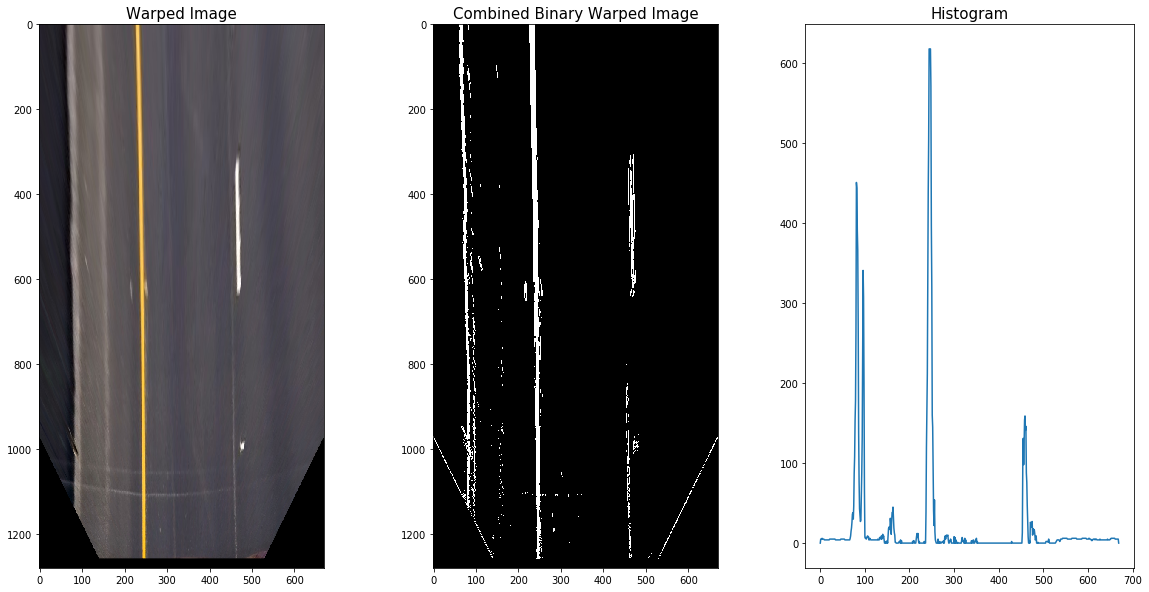

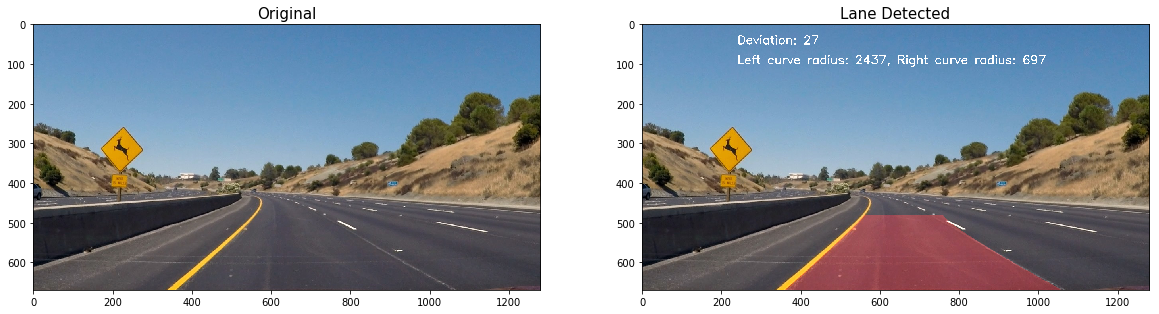

In [6]:
import os
from scipy import stats

def radius_of_curvature(leftx, lefty, rightx, righty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension 26/250
    xm_per_pix = 3.7/700 # meters per pixel in x dimension 3.7/224
    pixels_per_meter = [720/30, 700/3.7]
    y_eval = 670
    img_size = [670, 1280]
    # Fit new polynomials to x,y in world space
    #left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_fit_cr = np.polyfit(lefty, leftx, 2, rcond=1e-16)
    right_fit_cr = np.polyfit(righty, rightx, 2, rcond=1e-16)
    coeffs = (left_fit_cr + right_fit_cr) / 2
    
    shift = np.polyval(coeffs, img_size[1]/pixels_per_meter[1]) - (img_size[0]//2)/pixels_per_meter[0]
    
    # Calculate the new radii of curvature in meters
    left_curverad = ((1 + (2*left_fit_cr[0]*(y_eval/2) + left_fit_cr[1])**2)**1.5) // np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*(y_eval/2) + right_fit_cr[1])**2)**1.5) // np.absolute(2*right_fit_cr[0])
    
    curverad = ((1 + (2*coeffs[0]*(img_size[0]/2) + coeffs[1])**2)**1.5) // np.absolute(2*coeffs[0])

    return left_curverad*ym_per_pix, right_curverad*ym_per_pix, curverad*ym_per_pix

def visualizeWeighted(img, binary_warped, color_warp, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (255,0, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    return result


img_dir = '/Users/eren/CarND-Advanced-Lane-Lines/test_images/'
images = os.listdir(img_dir)

i = 3

print(img_dir + images[i])

img = plt.imread(img_dir + images[i])
img = img[0:img.shape[0] - 50, :]
img_size = (img.shape[0], img.shape[1])
    
_, combined_binary = binary(img)

M, Minv = bird_eye(img)

warped = cv2.warpPerspective(img, M, (img_size[0], img_size[1]))

color_warped, binary_warped = binary(warped)
out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

histogram = lane_histogram(binary_warped)
leftx_base, rightx_base = lane_peaks(histogram)
mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
car_pos = binary_warped.shape[1] / 2 

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20,10))
ax1.imshow(warped)
ax1.set_title('Warped Image', fontsize = 15)
plt.imsave(images[i] + "_warped.png", warped, cmap = 'gray')

ax2.imshow(binary_warped, cmap = "gray")
ax2.set_title('Combined Binary Warped Image', fontsize = 15)
ax3.plot(histogram)
ax3.set_title('Histogram', fontsize = 15)

out_img, color_warp, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = sliding_window_search(img, combined_binary, binary_warped, leftx_base, rightx_base)

lane_width = leftx_base - rightx_base
left_curverad, right_curverad, curverad = radius_of_curvature(leftx, lefty, rightx, righty)

mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
car_pos = binary_warped.shape[1] / 2
deviation = int(abs(mid_of_lane - car_pos) * (3.7 / 224) * 100)  

result = visualizeWeighted(img, binary_warped, color_warp, Minv, left_fitx, right_fitx, ploty)

print("Deviation: ", int(abs(mid_of_lane - car_pos) * (3.7 / 224) * 100), "cm")
print("Left curve radius: ", int(left_curverad), 'm', "Left curve radius: ",  int(right_curverad), 'm')
print("Curve radius: ", int(curverad))

deviation_text = "Deviation: "
radiusl_text = "Left curve radius: "
radiusr_text = "Right curve radius: "

cv2.putText(result, deviation_text + str(deviation), (240, 50), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255), 2)
cv2.putText(result, radiusl_text + str(int(left_curverad)) + ", " + radiusr_text + str(int(right_curverad)), (240, 100), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255), 2)

    
f2, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,10))
ax1.imshow(img)
ax1.set_title('Original', fontsize = 15)
ax2.imshow(result, cmap = 'gray')
ax2.set_title('Lane Detected', fontsize = 15)


/Users/eren/CarND-Advanced-Lane-Lines/test_images/straight_lines1.jpg


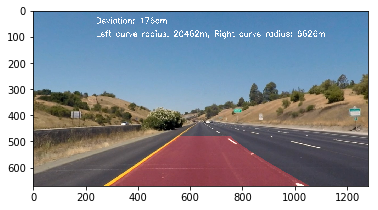

/Users/eren/CarND-Advanced-Lane-Lines/test_images/straight_lines2.jpg


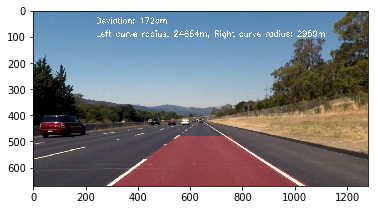

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test1.jpg


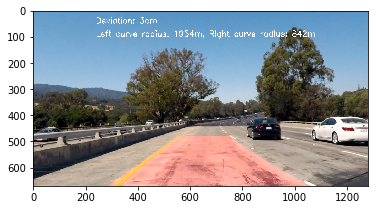

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test2.jpg


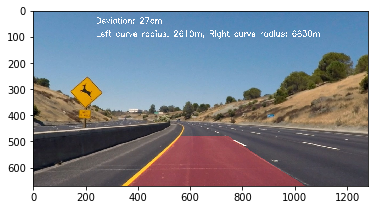

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test3.jpg


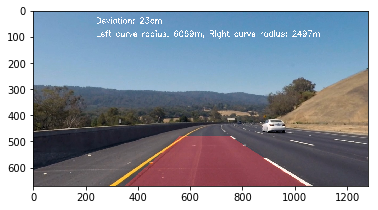

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test4.jpg


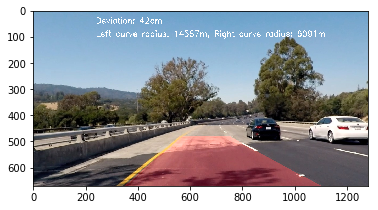

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test5.jpg


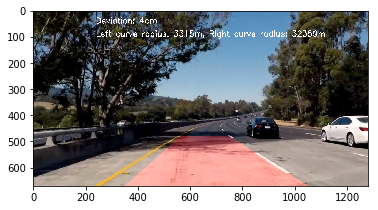

/Users/eren/CarND-Advanced-Lane-Lines/test_images/test6.jpg


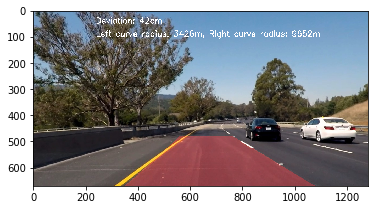

In [7]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import pickle

leftx_base_old = None
rightx_base_old = None

def process_image(img_raw, deviation_threshold=50):
    
    dist_pickle = pickle.load( open( "/Users/eren/CarND-Advanced-Lane-Lines/camera_cal/wide_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    img = cv2.undistort(img_raw, mtx, dist, None, mtx)
    
    img = img[0:img.shape[0] - 50, :]
    img_size = (img.shape[0], img.shape[1])
    
    _, combined_binary = binary(img)

    M, Minv = bird_eye(img)

    warped = cv2.warpPerspective(img, M, (img_size[0], img_size[1]))

    color_warped, binary_warped = binary(warped)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    
    #plt.imshow(color_warped, cmap="gray")
    #plt.imsave(image + "_found.png", result)
    #plt.show()
    
    histogram = lane_histogram(binary_warped)
    leftx_base, rightx_base = lane_peaks(histogram)
    mid_of_lane = leftx_base + (rightx_base - leftx_base) / 2
    car_pos = binary_warped.shape[1] / 2
    deviation = int(abs(mid_of_lane - car_pos) * (3.7 / 224) * 100)   

    global leftx_base_old
    global rightx_base_old
    #print("before", abs(leftx_base - rightx_base))
    
    if (leftx_base_old == None):
        leftx_base_old = leftx_base
        
    if (rightx_base_old == None):
        rightx_base_old = rightx_base

    if (abs(leftx_base - rightx_base) < 250) & (abs(leftx_base - rightx_base) > 160):
        leftx_base_old = leftx_base
        rightx_base_old = rightx_base
    else:
        leftx_base = leftx_base_old
        rightx_base = rightx_base_old
        
    #print("after", abs(leftx_base - rightx_base))

    out_img, color_warp, leftx, lefty, rightx, righty, left_fit, right_fit, left_fitx, right_fitx, ploty = sliding_window_search(img, combined_binary, binary_warped, leftx_base, rightx_base)

    lane_width = leftx_base - rightx_base
    left_curverad, right_curverad, curverad = radius_of_curvature(leftx, lefty, rightx, righty)
    
    result = visualizeWeighted(img, binary_warped, color_warp, Minv, left_fitx, right_fitx, ploty)
    
    deviation_text = "Deviation: "
    radiusl_text = "Left curve radius: "
    radiusr_text = "Right curve radius: "

    cv2.putText(result, deviation_text + str(deviation) + "cm", (240, 50), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255), 2)
    cv2.putText(result, radiusl_text + str(int(left_curverad)) + "m, " + radiusr_text + str(int(right_curverad)) + "m", (240, 100), cv2.FONT_HERSHEY_SIMPLEX,1 ,(255,255,255), 2)

    return result

img_dir = '/Users/eren/CarND-Advanced-Lane-Lines/test_images/'
images = os.listdir(img_dir)

for image in images:
    print(img_dir + image)
    img = plt.imread(img_dir + image)
    result = process_image(img, 100)
    plt.imshow(result)
    #plt.imsave(image + "_found.png", result)
    plt.show()  

In [8]:
video_dir = '/Users/eren/CarND-Advanced-Lane-Lines/'
white_output = 'deneme_v12.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video deneme_v12.mp4
[MoviePy] Writing video deneme_v12.mp4


100%|█████████▉| 1260/1261 [10:11<00:00,  2.11it/s]    | 1/1261 [00:00<10:34,  1.98it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: deneme_v12.mp4 

CPU times: user 10min 13s, sys: 1min 17s, total: 11min 30s
Wall time: 10min 13s


In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))